In [1]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [160]:
x_path = 'processed/125/Medium_pixelate'
y_path = 'dataset/125'

x_path_blur = 'processed/125/Medium_blur'
y_path_blur = 'dataset/125'

In [161]:
def read_data(x_path, y_path):
    X = []
    Y = []
    
    with os.scandir(x_path) as entries:
        for entry in entries:
            X.append(keras.preprocessing.image.img_to_array(
                keras.preprocessing.image.load_img(
                    os.path.join(x_path, entry.name)
            ))/255.0)
            Y.append(keras.preprocessing.image.img_to_array(
                keras.preprocessing.image.load_img(
                    os.path.join(y_path, entry.name)
            ))/255.0)
        
    return np.array(X), np.array(Y)

In [162]:
X_blur, Y_blur = read_data(x_path_blur, y_path_blur)

X_train_blur, Y_train_blur, X_test_blur, Y_test_blur = X_blur[:10000], Y_blur[:10000], X_blur[10000:], Y_blur[10000:]

In [163]:
X, Y = read_data(x_path, y_path)

X_train, Y_train, X_test, Y_test = X[:10000], Y[:10000], X[10000:], Y[10000:]

In [176]:
print(X_blur.shape)
print(X.shape)

(13140, 125, 125, 3)
(13140, 125, 125, 3)


In [ ]:
t = X[:4]
idx = np.random.permutation(t.shape[0])



In [ ]:
print(X[:4])
print(t)

In [ ]:
def merge(blur, pixelate):
    X = np.append(blur[0], pixelate[0])
    Y = np.append(blur[1], pixelate[1])
    
    idx = np.random.permutation(X.shape[0])
    X = X[idx]
    Y = Y[idx]

    return X, Y
    
X_all, Y_all = merge((X_blur, Y_blur), (X, Y))

In [ ]:
print(X_all.shape)
print(type(X_all[0,0,0,0]))
print(type(Y_all[0,0,0,0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


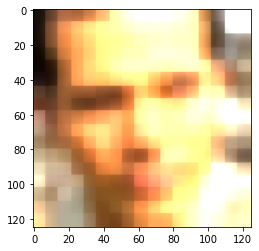

In [174]:
imgplot = plt.imshow(X_all[220])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


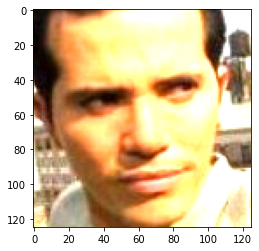

In [175]:
imgplot = plt.imshow(Y_all[220])
plt.show()

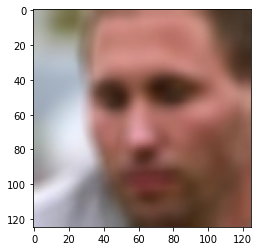

In [13]:
imgplot = plt.imshow(X_train_blur[0])
plt.show()

In [118]:
def pixel_loss(input_shape):
    assert input_shape is not None
    
    input_shape = np.array(input_shape).astype('float32')
    def loss(y_true, y_pred):
        return tf.math.square(tf.norm(y_pred - y_true)) / tf.math.reduce_prod(input_shape)
    
    return loss


In [496]:
def build_conv_block(prev, filters, kernel_size, strides):
    conv = keras.layers.Conv2D(filters=filters, 
                               kernel_size=kernel_size, strides=strides,
                              activation='relu')(prev),
    conv = keras.layers.BatchNormalization()(conv)
    
    return conv

def build_deconv_block(filters, kernel_size, strides, activation='relu'):
    deconv = keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides,
                              activation=activation),
    deconv = keras.layers.BatchNormalization()(deconv)
    return deconv
    



In [460]:
def build_model_2(input_shape):
    
    input_layer = keras.layers.Input(input_shape)
    
    conv_block1 = build_conv_block(input_layer, filters=64, kernel_size=9, strides=1)
    conv_block2 = build_conv_block(conv_block1, filters=64, kernel_size=4, strides=2)
    conv_block3 = build_conv_block(conv_block2, filters=128, kernel_size=4, strides=2)
    conv_block4 = build_conv_block(conv_block3, filters=3, kernel_size=4, strides=2)

    res1 = residual(conv_block4)
    res2 = residual(res1)
    res3 = residual(res2)
        
    devconv_1 = build_deconv_block(filters=256, kernel_size=4, strides=2)(res3)
    devconv_2 = build_deconv_block(filters=128, kernel_size=4, strides=2)(devconv_1)
    devconv_3 = build_deconv_block(filters=64, kernel_size=9, strides=2)(devconv_2)
    devconv_4 = build_deconv_block(filters=3, kernel_size=9, strides=2, activation='sigmoid')(devconv_3)

    output_layer = keras.layers.experimental.preprocessing.Rescaling(scale=255.0)(devconv_4)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer="adam",
        loss='mse',
        metrics=['accuracy'],
    )
    return model

In [493]:
def build_model(input_shape):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(input_shape=input_shape, filters=64, kernel_size=9, strides=1)),
    model.add(keras.layers.BatchNormalization(),)
    model.add(keras.layers.Activation(keras.activations.relu),)

    model.add(keras.layers.Conv2D(filters=64, kernel_size=4, strides=2),)
    model.add(keras.layers.BatchNormalization(),)
    model.add(keras.layers.Activation(keras.activations.relu),)

    model.add(keras.layers.Conv2D(filters=128, kernel_size=4, strides=2),)
    model.add(keras.layers.BatchNormalization(),)
    model.add(keras.layers.Activation(keras.activations.relu),)

    model.add(keras.layers.Conv2D(filters=3, kernel_size=4, strides=2),)
    model.add(keras.layers.BatchNormalization(),)
    model.add(keras.layers.Activation(keras.activations.relu),)

    conv = keras.layers.Conv2D(filters=3, kernel_size=4, strides=2)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Activation(keras.activations.relu)(conv)

    res = residual(conv)
    res = residual(res)
    res = residual(res)
    model.add(res)

    model.add(keras.layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2),)
    model.add(keras.layers.BatchNormalization(),)
    model.add(keras.layers.Activation(keras.activations.relu),)

    model.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2),)
    model.add(keras.layers.BatchNormalization(),)
    model.add(keras.layers.Activation(keras.activations.relu),)

    model.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=9, strides=2),)
    model.add(keras.layers.BatchNormalization(),)
    model.add(keras.layers.Activation(keras.activations.relu),)

    model.add(keras.layers.Conv2DTranspose(filters=3, kernel_size=9, strides=2),)
    model.add(keras.layers.BatchNormalization(),)
    model.add(keras.layers.Activation(keras.activations.tanh),)
    model.compile(
        optimizer="adam",
        loss='mse',
        metrics=['accuracy'],
    )
    return model

In [140]:
def build_model_1(input_shape, upscale_factor=1, channels=3):
        inputs = keras.layers.Input(shape=input_shape)
        x = keras.layers.Conv2D(filters=128, kernel_initializer='glorot_uniform',
                                kernel_size=(9, 9), padding='same',
                                activation='relu')(inputs)
        x = keras.layers.Conv2D(filters=64, kernel_initializer='glorot_uniform', 
                                kernel_size=(1, 1), padding='same',
                                activation='relu')(x)
        outputs = keras.layers.Conv2D(filters=3, kernel_initializer='glorot_uniform',
                                      kernel_size=(5, 5), padding='same',
                                      activation='relu')(x)
        
        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=pixel_loss(input_shape),
            metrics=['accuracy'],
        )
        return model

In [141]:
model = build_model_1(X.shape[1:])
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 125, 125, 128)     31232     
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 125, 125, 64)      8256      
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 125, 125, 3)       4803      
Total params: 44,291
Trainable params: 44,291
Non-trainable params: 0
_________________________________________________________________


In [143]:
X_train_1, Y_train_1 = X_train[:5000], Y_train[:5000]

history1 = model.fit(X_train, Y_train, validation_split=0.1, epochs=10, verbose=1)

Epoch 1/10
282/282 [==============================] - 587s 2s/step - loss: 0.1321 - accuracy: 0.9363 - val_loss: 0.1141 - val_accuracy: 0.9542
Epoch 2/10
282/282 [==============================] - 572s 2s/step - loss: 0.0995 - accuracy: 0.9482 - val_loss: 0.0911 - val_accuracy: 0.9499
Epoch 3/10
282/282 [==============================] - 601s 2s/step - loss: 0.0966 - accuracy: 0.9485 - val_loss: 0.0813 - val_accuracy: 0.9570
Epoch 4/10
282/282 [==============================] - 573s 2s/step - loss: 0.0918 - accuracy: 0.9528 - val_loss: 0.0828 - val_accuracy: 0.9542
Epoch 5/10
282/282 [==============================] - 572s 2s/step - loss: 0.0901 - accuracy: 0.9528 - val_loss: 0.0807 - val_accuracy: 0.9549
Epoch 6/10
282/282 [==============================] - 575s 2s/step - loss: 0.0891 - accuracy: 0.9534 - val_loss: 0.0800 - val_accuracy: 0.9584
Epoch 7/10
282/282 [==============================] - 573s 2s/step - loss: 0.0890 - accuracy: 0.9523 - val_loss: 0.0856 - val_accuracy: 0.9498

In [159]:
def save_model(model, name):
    model.save(f'./best_model_{name}.tf')
    
#save_model(model, 'apr-14_light pixelate')

INFO:tensorflow:Assets written to: ./best_model_apr-14_light pixelate.tf/assets


In [146]:
t = model.predict(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


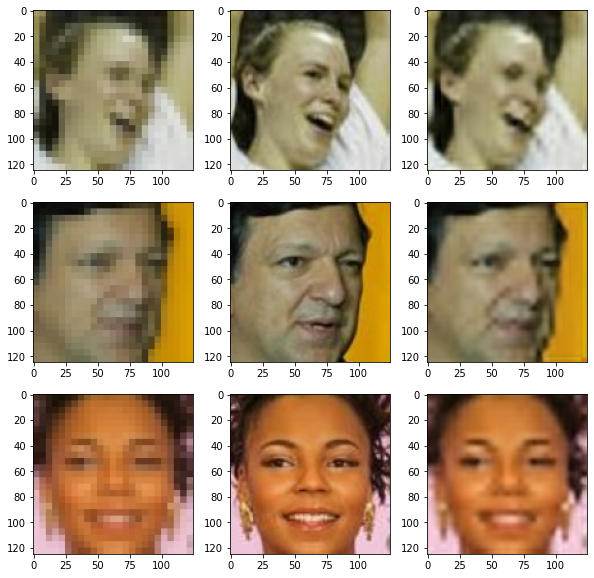

In [145]:


fig, ax = plt.subplots(3, 3, figsize=(10,10))

for i in range(3):
    ax[i, 0].imshow(X_test[i+2])
    ax[i, 1].imshow(Y_test[i+2])
    ax[i, 2].imshow(t[i+2])
    

plt.show()

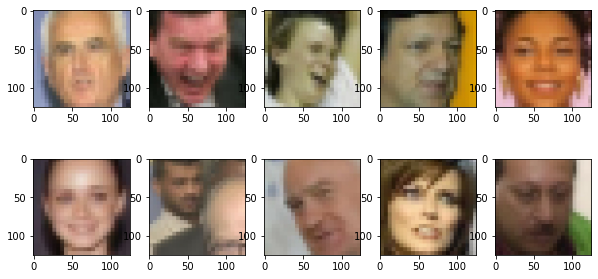

In [149]:
fig, ax = plt.subplots(2, 5, figsize=(10,5))

cnt = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(X_test[cnt])
        cnt += 1

plt.show()

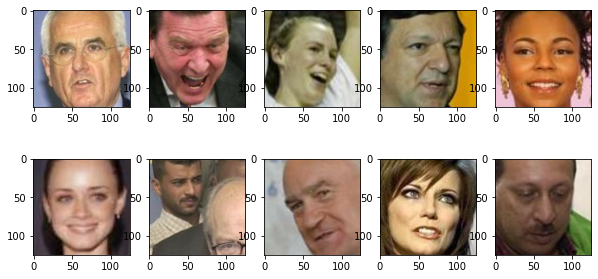

In [148]:
fig, ax = plt.subplots(2, 5, figsize=(10,5))

cnt = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(Y_test[cnt])
        cnt += 1

plt.show()

In [156]:
sin_img = keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(
            os.path.join('processed/125/Medium_pixelate', 'Aaron_Eckhart_0001.jpg')
    ))/255.0
ing =  model.predict(np.array([sin_img]))

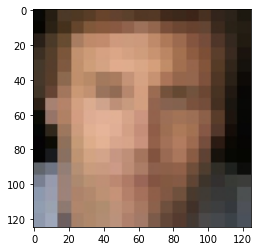

In [157]:
plt.imshow(sin_img)

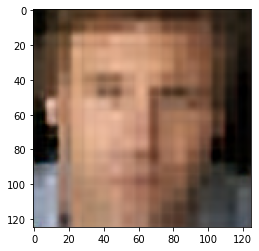

In [158]:
plt.imshow(ing[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


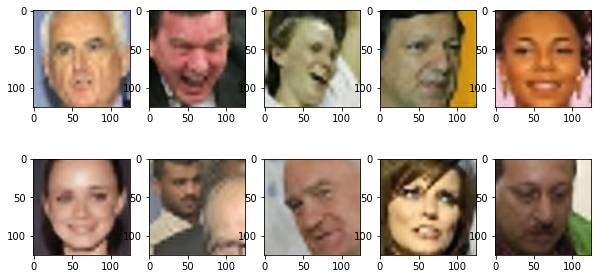

In [147]:
fig, ax = plt.subplots(2, 5, figsize=(10,5))

cnt = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(t[cnt])
        cnt += 1

plt.show()